# Notebook for Article: "AB Testing - Frequentist VS Bayesian Approach"

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
import math

from scipy import stats

import pymc as pm
# import arviz as az

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

import hashlib

In [2]:
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.5.0


# Test #1

## Generate some Data

##### Generate a row of descrete random events and add a number of outliers

In [3]:
# Generate a row of descrete random events
control = stats.poisson.rvs(mu=0.9, loc=0, size=100000, random_state=12)
test = stats.poisson.rvs(mu=0.908, loc=0, size=100000, random_state=12)
# Add a number of outliers
n_outliers = 5
control = np.append(control, np.random.default_rng(12).integers(0, 8, n_outliers))
test = np.append(test, np.random.default_rng(14).integers(10, 20, n_outliers))

##### Assign hashes

In [4]:
control_id = np.array([int(hashlib.md5(f'hash{str(i)}'.encode('utf_8')).hexdigest(), 16) for i in range(len(control))])
test_id = np.array([int(hashlib.md5(f'hash{str(i)}'.encode('utf_8')).hexdigest(), 16) for i in range(len(test))])

if len(set(test_id)) == len(test) and len(set(control_id)) == len(control):
    print('Hashes assigned')
else:
    print('Error')

Hashes assigned


##### Create DataFrame with prepared data

In [5]:
# Add division by Control and Test groups
data = pd.DataFrame(
    data={
        'id': np.r_[control_id, test_id],
        'group_name': np.r_[np.repeat('Control', len(control)), np.repeat('Test', len(test))],
        'ride_request_clicks': np.r_[control, test]
    }
)
# Create CR metric
data['ride_request_is_click'] = data['ride_request_clicks'] > 0
data.head(4)

,id,group_name,ride_request_clicks,ride_request_is_click
0,294656076722992131643929581989213614422,Control,0,False
1,1032905646386335856508929738930080603,Control,1,True
2,117653356252977005139235343122285202191,Control,1,True
3,34968446932843456519540442248542660464,Control,2,True


## Observe the Data

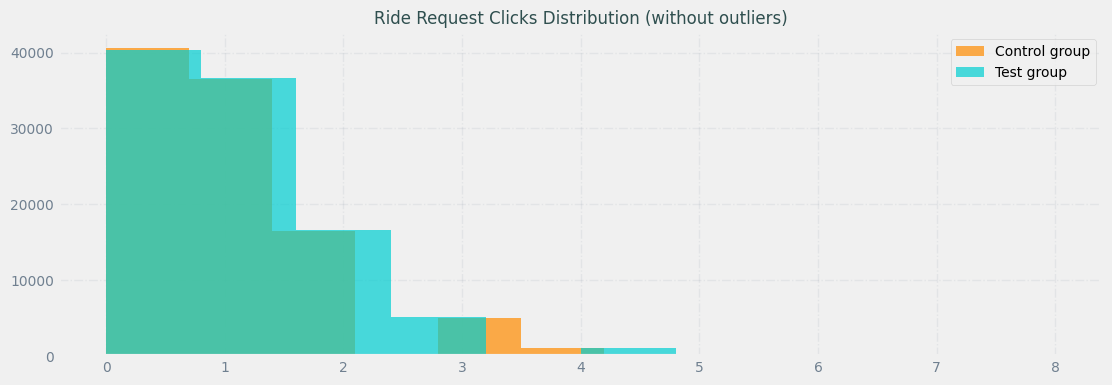

In [6]:
plt.figure(figsize=(12, 4))

plt.title('Ride Request Clicks Distribution (without outliers)', color='darkslategrey', fontsize=12)
plt.hist(control[:-n_outliers], alpha=.7, color='darkorange', label='Control group')
plt.hist(test[:-n_outliers], alpha=.7, color='darkturquoise', label='Test group')

plt.xticks(color='slategrey', size=10)
plt.yticks(color='slategrey', size=10)
plt.grid(visible='both', which='major', linestyle='-.', color='slategrey', alpha=.1)

plt.legend(fontsize=10)
plt.show()

In [7]:
data_decriber = pd.DataFrame(data={'Control': control, 'Test': test})
data_decriber.describe()

,Control,Test
count,100005.000000,100005.000000
mean,0.900465,0.909055
std,0.949198,0.957498
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,1.000000
75%,1.000000,1.000000
max,7.000000,18.000000


In [8]:
print(f'Zero requests share in Control group: {round(sum(control==0) / len(control) * 100, 2)}%')
print(f'Zero requests share in Test group: {round(sum(test==0) / len(test) * 100, 2)}%')

Zero requests share in Control group: 40.66%
Zero requests share in Test group: 40.33%


## Bucketization

##### Group the users by 100 buckets

In [13]:
data['bucket_id'] = data.apply(lambda x: x['id'] % 100, axis=1)

##### Metrics summary by bucket data

In [14]:
data.groupby('group_name').agg({
    'id': 'count', 
    'bucket_id': 'nunique',
    'ride_request_clicks': ['sum', 'mean', 'std'], 
    'ride_request_is_click': ['sum', 'mean', 'std']
}).head(5)

id bucket_id ride_request_clicks                      \
             count   nunique                 sum      mean       std   
group_name                                                             
Control     100005       100               90051  0.900465  0.949198   
Test        100005       100               90910  0.909055  0.957498   

           ride_request_is_click                     
                             sum     mean       std  
group_name                                           
Control                    59346  0.59343  0.491196  
Test                       59677  0.59674  0.490555

##### Group data by group name and bucket id calculating mean metrics

In [15]:
data_aggr = data.groupby(['group_name', 'bucket_id'])[['ride_request_clicks', 'ride_request_is_click']].mean()
data_aggr.head()

ride_request_clicks  ride_request_is_click
group_name bucket_id                                            
Control    0                     0.891089               0.600000
           1                     0.884347               0.595214
           2                     0.900513               0.602051
           3                     0.878882               0.595238
           4                     0.931683               0.588119

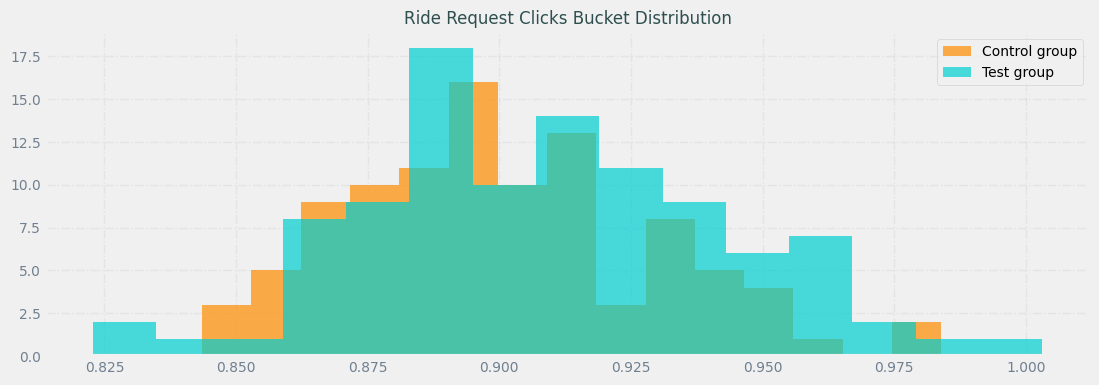

In [16]:
plt.figure(figsize=(12, 4))

plt.title('Ride Request Clicks Bucket Distribution', color='darkslategrey', fontsize=12)
plt.hist(
    data_aggr[data_aggr.index.get_level_values(0) == 'Control'].ride_request_clicks.values,
    bins=15,
    alpha=.7, 
    color='darkorange',
    label='Control group'
)
plt.hist(
    data_aggr[data_aggr.index.get_level_values(0) == 'Test'].ride_request_clicks.values,
    bins=15,
    alpha=.7,
    color='darkturquoise',
    label='Test group'
)

plt.xticks(color='slategrey', size=10)
plt.yticks(color='slategrey', size=10)
plt.grid(visible='both', which='major', linestyle='-.', color='slategrey', alpha=.1)

plt.legend(fontsize=10)
plt.show()

## Perform AB Frequentist Approach with T-test

In [17]:
def t_test(x: list, y: list) -> (float, float):
    # Number of observations
    n_X = len(x)
    n_Y = len(y)
    # Samples' means
    mean_X = x.mean()
    mean_Y = y.mean()
    # Samples' variances
    var_X = x.var(ddof=1) # The number of degrees of freedom
    var_Y = y.var(ddof=1) # The number of degrees of freedom

    # Pooled Standard Deviation    
    pooled_std = np.sqrt(var_X / n_X + var_Y / n_Y)
    # t-statistics
    t_stat = (mean_X - mean_Y) / pooled_std

    # The degrees of freedom
    # ddof = n_X + n_Y - 2 # ddof for equal variance
    # ddof for unequal variance by Welch–Satterthwaite equation
    ddof = (var_X / n_X + var_Y / n_Y)**2 / ((var_X / n_X)**2 / (n_X - 1) + (var_Y / n_Y)**2 / (n_Y - 1))

    # P-Value
    # p_value = 2 * (1 - stats.t.cdf(abs(t_stat), ddof))
    # Survival function is more accurate Cumulative Density Function
    p_value = 2 * stats.t.sf(abs(t_stat), ddof)
    
    return t_stat, p_value

### Mean metric

##### Full data with outliers

In [18]:
t_stat, p_value = t_test(
    data[data.group_name == 'Test'].ride_request_clicks.values,
    data[data.group_name == 'Control'].ride_request_clicks.values
)
print('t-statistics:', round(t_stat, 3), 'p-value:', round(p_value, 5),
     'Significant' if p_value < .05 else 'Non Significant'
)

t-statistics: 2.015 p-value: 0.04394 Significant


##### Full data without outliers

In [19]:
t_stat, p_value = t_test(
    data[data.group_name == 'Test'].ride_request_clicks.values[:-n_outliers],
    data[data.group_name == 'Control'].ride_request_clicks.values[:-n_outliers]
)
print('t-statistics:', round(t_stat, 3), 'p-value:', round(p_value, 5),
     'Significant' if p_value < .05 else 'Non Significant'
)

t-statistics: 1.907 p-value: 0.05652 Non Significant


##### Bucket data with outliers

In [20]:
t_stat, p_value = t_test(
    data_aggr[data_aggr.index.get_level_values(0) == 'Test'].ride_request_clicks.values,
    data_aggr[data_aggr.index.get_level_values(0) == 'Control'].ride_request_clicks.values,
)
print('t-statistics:', round(t_stat, 3), 'p-value:', round(p_value, 5),
     'Significant' if p_value < .05 else 'Non Significant'
)

t-statistics: 1.948 p-value: 0.05288 Non Significant


> Using bucket data the result is non significant. It means that outliers gained false difference between groups

### CR metric

In [21]:
def z_test(x: list, y: list) -> (float, float):
    # Number of observations
    n1 = len(x)
    n2 = len(y)
    # Samples' means -> Proportions
    p1 = x.mean()
    p2 = y.mean()
    
    # z-score
    z_score = abs(p1 - p2) / np.sqrt(p1*(1-p1)/n1 + p2*(1-p2)/n2)
    # p-value
    p_value = (1 - stats.norm.cdf(np.abs(z_score))) * 2
    # Survival function is more accurate Cumulative Density Function
    p_value = stats.norm.sf(np.abs(z_score)) * 2
    
    return z_score, p_value

##### CR metric estimated via Z-Test

In [22]:
z_score, p_value = z_test(
    data[data.group_name == 'Test'].ride_request_is_click.values,
    data[data.group_name == 'Control'].ride_request_is_click.values
)
print('z_score:', round(z_score, 3), 'p-value:', round(p_value, 5),
     'Significant' if p_value < .05 else 'Non Significant'
)

z_score: 1.508 p-value: 0.13162 Non Significant


##### CR metric estimated via T-Test

In [23]:
t_stat, p_value = t_test(
    data[data.group_name == 'Test'].ride_request_is_click.values,
    data[data.group_name == 'Control'].ride_request_is_click.values
)
print('t-statistics:', round(t_stat, 3), 'p-value:', round(p_value, 5),
     'Significant' if p_value < .05 else 'Non Significant'
)

t-statistics: 1.508 p-value: 0.13162 Non Significant


## Perform Bayesian Model

### Mean metric

In [24]:
test_values = data_aggr[data_aggr.index.get_level_values(0) == 'Test'].ride_request_clicks.values
control_values = data_aggr[data_aggr.index.get_level_values(0) == 'Control'].ride_request_clicks.values

In [25]:
pooled_mean = np.r_[test_values, control_values].mean()
pooled_std = np.r_[test_values, control_values].std()

tau = 1. / np.sqrt(1000. * pooled_std)

In [26]:
with pm.Model() as model:
    # Set the prior means
    mu_Test = pm.Normal('mu_Test', mu=pooled_mean, tau=tau)
    mu_Control = pm.Normal('mu_Control', mu=pooled_mean, tau=tau)
    
    # Set the prior standard deviations
    std_Test = pm.Uniform('std_Test', pooled_std / 1000., pooled_std * 1000.)
    std_Control = pm.Uniform('std_Control', pooled_std / 1000., pooled_std * 1000.)

    # Set the prior for degrees of freedom
    nu_minus_1 = pm.Exponential('nu-1', 1./29)
    
    obs_Test = pm.StudentT('obs_Test',
                       nu=nu_minus_1+1,
                       mu=mu_Test,
                       sigma=1.0/std_Test**2,
                       observed=test_values)
    
    obs_Control = pm.StudentT('obs_Control',
                       nu=nu_minus_1+1,
                       mu=mu_Control,
                       sigma=1.0/std_Control**2,
                       observed=control_values)
    
    diff_of_means = pm.Deterministic('difference of means',  mu_Test-mu_Control)
    uplift = pm.Deterministic('uplift', diff_of_means / mu_Control)
    diff_of_stds = pm.Deterministic('difference of stds',  std_Test-std_Control)
    effect_size = pm.Deterministic('effect size',
                                   diff_of_means / np.sqrt((std_Test**2 + std_Control**2) / 2))

In [27]:
with model:
    start = pm.find_MAP()
    step = pm.Metropolis(vars=[mu_Test, mu_Control, std_Test, std_Control, nu_minus_1])

In [28]:
with model:
    trace = pm.sample(draws=25000, tune=5000, cores=6, step=step, initvals=start)

Multiprocess sampling (6 chains in 6 jobs)
CompoundStep
>Metropolis: [mu_Test]
>Metropolis: [mu_Control]
>Metropolis: [std_Test]
>Metropolis: [std_Control]
>Metropolis: [nu-1]


Sampling 6 chains for 5_000 tune and 25_000 draw iterations (30_000 + 150_000 draws total) took 16 seconds.


In [29]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

#### Visualization

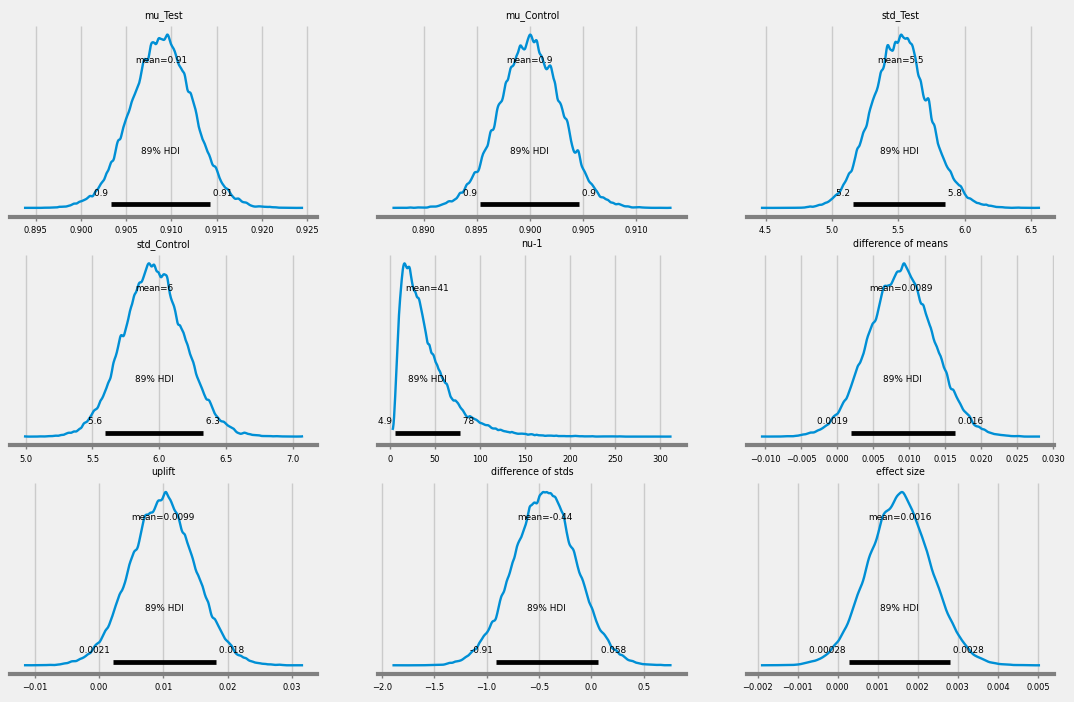

In [189]:
pm.plot_posterior(
    data=trace,
    figsize=(12,8),
    textsize=6,
    hdi_prob=.89
);

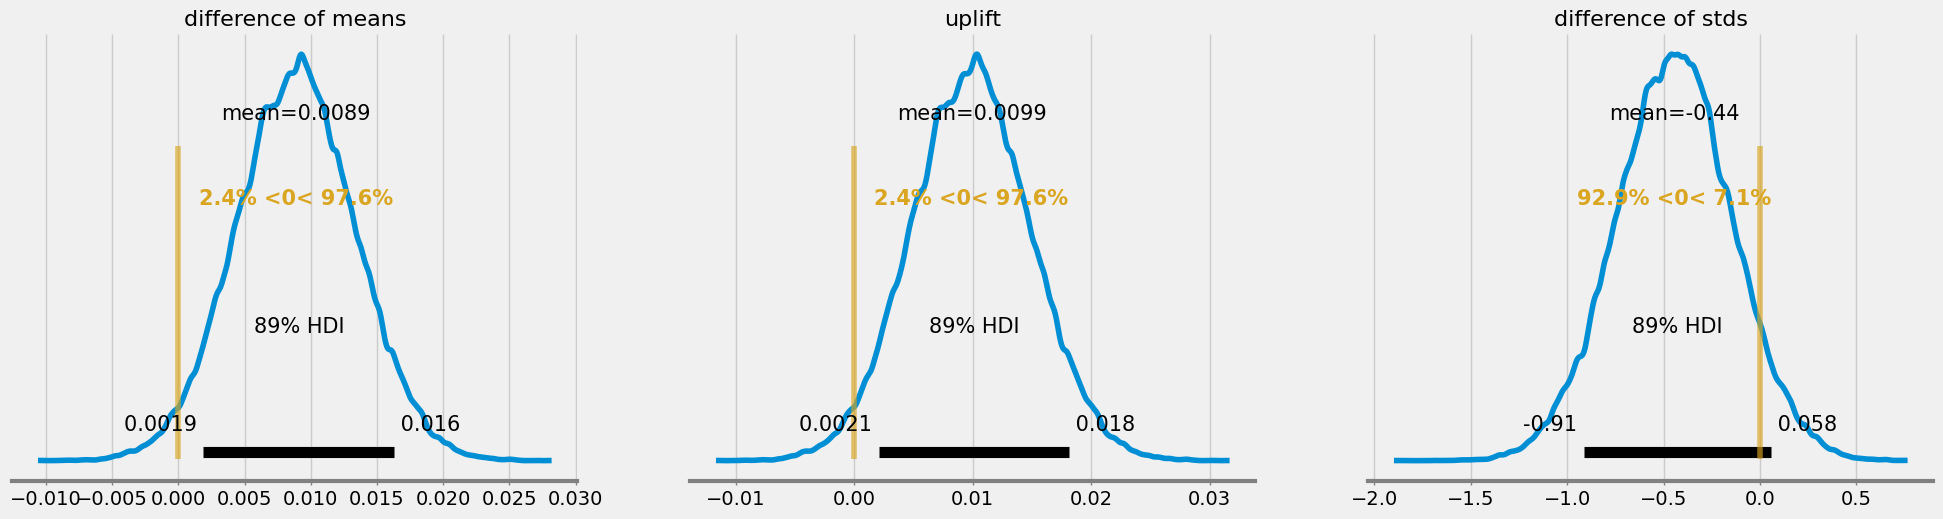

In [188]:
pm.plot_posterior(
    data=trace,
    var_names=['difference of means', 'uplift', 'difference of stds'],
    ref_val=0,
    ref_val_color='goldenrod',
    hdi_prob=.89
);

In [154]:
def prob_compare_posterior_diff_to_threshold(trace, metric, threshold):
    return np.mean(np.concatenate(trace.posterior[metric]) > threshold)

In [169]:
print(f'Probability of Test Mean is higher than Control:\
 {round(prob_compare_posterior_diff_to_threshold(trace, "difference of means", 0), 5)}')

Probability of Test Mean is higher than Control: 0.97573


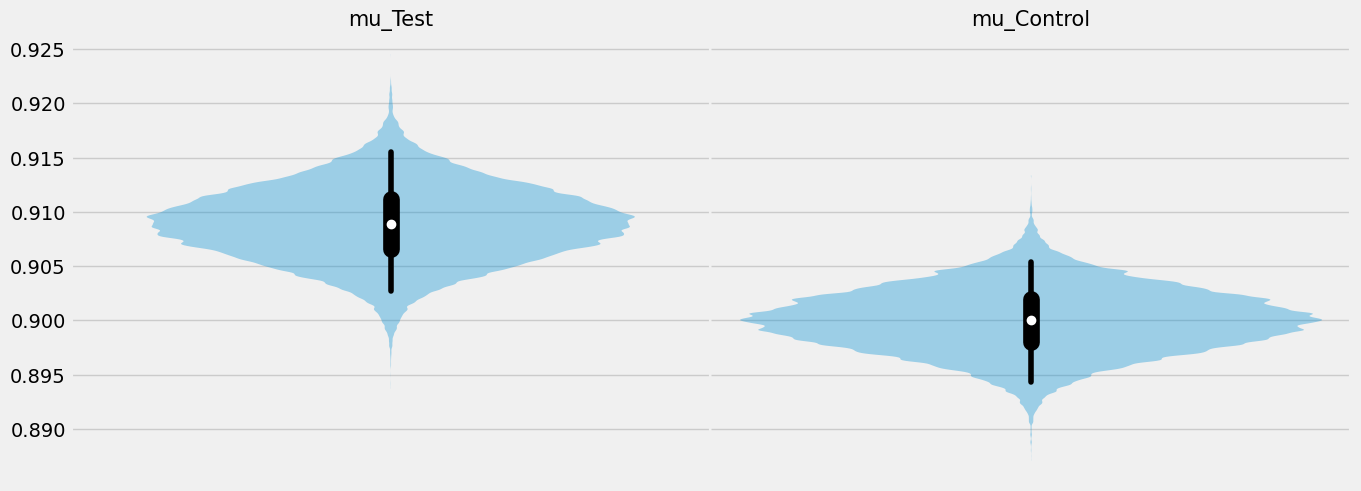

In [42]:
pm.plot_violin(trace, var_names=["mu_Test", "mu_Control"]);

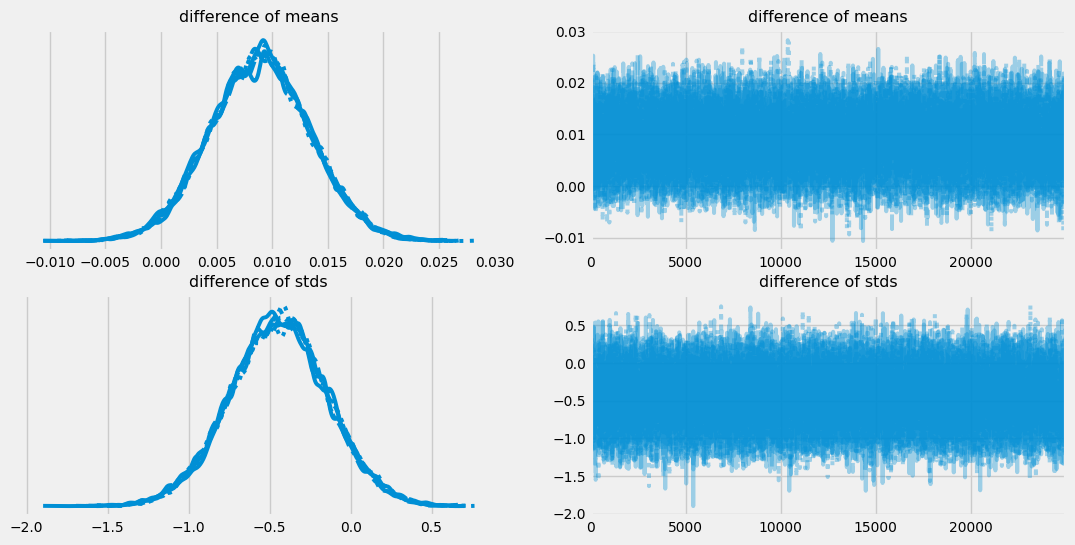

In [56]:
pm.plot_trace(
    data=trace.posterior, 
    var_names=['difference of means', 'difference of stds'],
    figsize=(12,6)
);

#### Equivalence Test
[Region of Practical Equivalence (ROPE)](https://easystats.github.io/bayestestR/articles/region_of_practical_equivalence.html)

In [76]:
def equivalence_test(trace, metric, hdi_prob, rope_metric):
    values = np.concatenate(trace.posterior[metric])

    # HDI
    hdi = pm.stats.hdi(ary=values, hdi_prob=hdi_prob)
    # ROPE for t-test: [−0.1*SD_diff, 0.1*SD_diff]
    rope = np.array([-.1, .1]) * abs(np.concatenate(trace.posterior[rope_metric]).mean())

    value_within_hdi = values[(values > hdi.min()) & (values <= hdi.max())]
    hdi_intercept_rope = len(value_within_hdi[(value_within_hdi > rope.min()) & (value_within_hdi <= rope.max())]) / len(value_within_hdi)
    
    if hdi_intercept_rope == 1:
        result = 'ROPE completely covers HDI, “Null Hypothesis” is accepted'
    elif hdi_intercept_rope > 0: 
        result = f'ROPE partly covers HDI on {round(hdi_intercept_rope*100,2)}%'
    else:
        result = 'HDI is outside the ROPE, “Null Hypothesis” is rejected'
    
    # main plot
    pm.plot_posterior(
        figsize=(8,4),
        textsize=10,
        color='slategrey',
        linewidth=1.5,
        data=trace,
        var_names=metric,
        point_estimate='median',
        hdi_prob=hdi_prob,
        # rope=rope,
        # rope_color='green'
    )
    # threshold
    plt.axvspan(hdi[0], hdi[1], ymin=0.1, ymax=.9, alpha=0.7, color='cornflowerblue')
    plt.axvspan(rope[0], rope[1], ymin=0.1, ymax=.9, alpha=0.3, color='palegreen')

    plt.title(result, fontsize=10)
    plt.show()

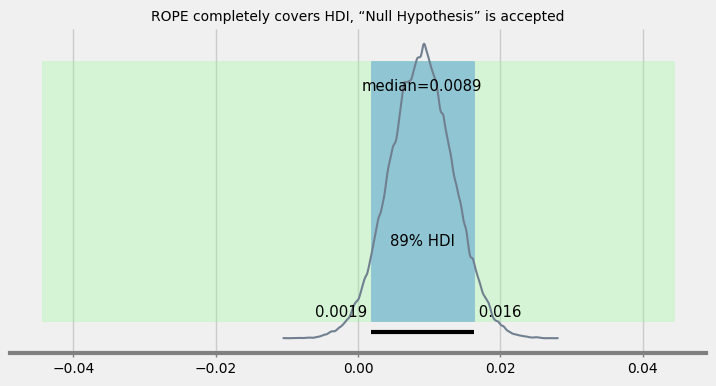

In [187]:
equivalence_test(trace, 'difference of means', .89, 'difference of stds')

#### Calculate Point Estimates

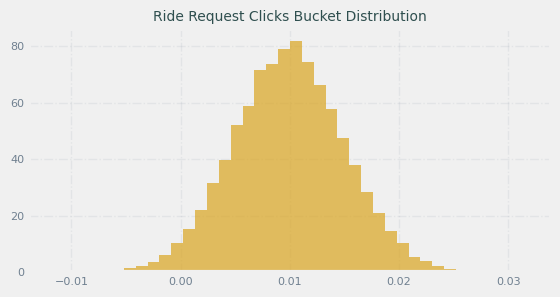

In [78]:
uplift = np.concatenate(trace.posterior['uplift'])

plt.figure(figsize=(6, 3))

plt.title('Ride Request Clicks Bucket Distribution', color='darkslategrey', fontsize=10)
plt.hist(
    uplift,
    color='goldenrod',
    alpha=.7,
    bins=40,
    density=True
)

plt.xticks(color='slategrey', size=8)
plt.yticks(color='slategrey', size=8)
plt.grid(visible='both', which='major', linestyle='-.', color='slategrey', alpha=.1)

plt.show();

In [81]:
uplift = np.concatenate(trace.posterior['uplift'])

perc_30 = np.percentile(uplift, 30)
perc_50 = np.percentile(uplift, 50)
perc_70 = np.percentile(uplift, 70)

def get_prob_from_point(arr, point):
    return np.sum(arr >= point) / len(arr)

print(f'{round(get_prob_from_point(uplift, perc_30)*100)}% probability to obtain uplift more than {round(perc_30*100,2)}%')
print(f'{round(get_prob_from_point(uplift, perc_50)*100)}% probability to obtain uplift more than {round(perc_50*100,2)}%')
print(f'{round(get_prob_from_point(uplift, perc_70)*100)}% probability to obtain uplift more than {round(perc_70*100,2)}%')


70% probability to obtain uplift more than 0.73%
50% probability to obtain uplift more than 0.99%
30% probability to obtain uplift more than 1.25%


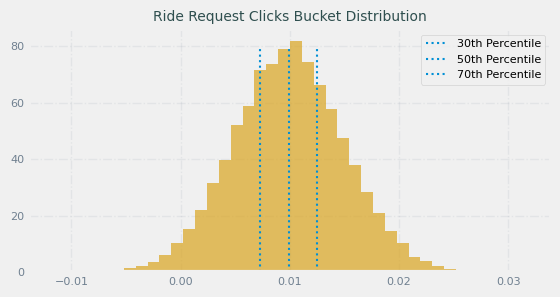

In [82]:
plt.figure(figsize=(6, 3))

plt.title('Ride Request Clicks Bucket Distribution', color='darkslategrey', fontsize=10)
plt.hist(
    uplift,
    color='goldenrod',
    alpha=.7,
    bins=40,
    density=True
)
plt.vlines(perc_30, 0, 80, linestyles='dotted', linewidth=1.5, label='30th Percentile')
plt.vlines(perc_50, 0, 80, linestyles='dotted', linewidth=1.5, label='50th Percentile')
plt.vlines(perc_70, 0, 80, linestyles='dotted', linewidth=1.5, label='70th Percentile')

plt.xticks(color='slategrey', size=8)
plt.yticks(color='slategrey', size=8)
plt.grid(visible='both', which='major', linestyle='-.', color='slategrey', alpha=.1)

plt.legend(fontsize=8)
plt.show();

### CR metric

In [83]:
control_values_raw = data[data.group_name == 'Control'].ride_request_is_click.values * 1
control_values_bucket = data_aggr[data_aggr.index.get_level_values(0) == 'Control'].ride_request_is_click.values

print('Raw data mean:', round(control_values_raw.mean(), 7))
print('Bucket data mean:', round(control_values_bucket.mean(), 7))

Raw data mean: 0.5934303
Bucket data mean: 0.5934157


#### Model for Raw Data

In [84]:
test_values = data[data.group_name == 'Test'].ride_request_is_click.values * 1
control_values = data[data.group_name == 'Control'].ride_request_is_click.values * 1

In [85]:
with pm.Model() as model_cr:
    # Set the prior means
    p_Test = pm.Uniform('p_Test', 0, 1)
    p_Control = pm.Uniform('p_Control', 0, 1)
    
    # Define the deterministic delta and uplift functions
    delta = pm.Deterministic('delta', p_Test - p_Control)
    uplift = pm.Deterministic('uplift', delta / p_Control)
    
    # Set of observations
    obs_Test = pm.Bernoulli('obs_Test', p_Test, observed=test_values)
    obs_Control = pm.Bernoulli('obs_Control', p_Control, observed=control_values)

    start = pm.find_MAP()
    step = pm.Metropolis(vars=[p_Test, p_Control])
    trace_cr = pm.sample(draws=25000, tune=5000, cores=6, step=step, initvals=start)

Multiprocess sampling (6 chains in 6 jobs)
CompoundStep
>Metropolis: [p_Test]
>Metropolis: [p_Control]


Sampling 6 chains for 5_000 tune and 25_000 draw iterations (30_000 + 150_000 draws total) took 29 seconds.


##### Visualization

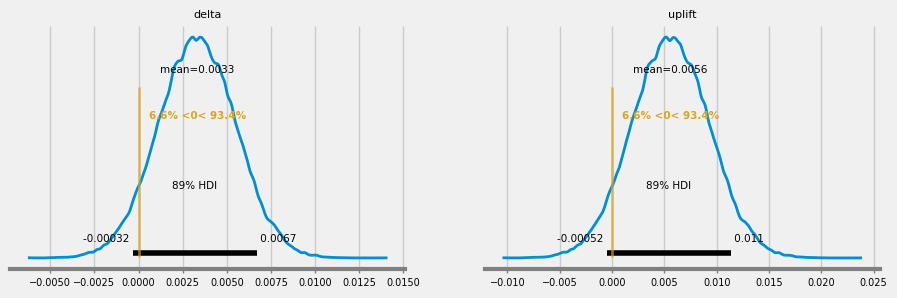

In [186]:
pm.plot_posterior(
    data=trace_cr,
    figsize=(10,3),
    textsize=7,
    var_names=['delta', 'uplift'],
    ref_val_color='goldenrod',
    ref_val=0,
    hdi_prob=.89
);

In [170]:
print(f'Probability of Test CR is higher than Control:\
 {round(prob_compare_posterior_diff_to_threshold(trace_cr, "delta", 0), 5)}')

Probability of Test CR is higher than Control: 0.93402


#### BEST Model for Bucket Data

In [88]:
test_values = data_aggr[data_aggr.index.get_level_values(0) == 'Test'].ride_request_is_click.values
control_values = data_aggr[data_aggr.index.get_level_values(0) == 'Control'].ride_request_is_click.values

In [89]:
pooled_mean = np.r_[test_values, control_values].mean()
pooled_std = np.r_[test_values, control_values].std()

tau = 1. / np.sqrt(1000. * pooled_std)

In [90]:
with pm.Model() as model_cr_best:
    # Set the prior means
    mu_Test = pm.Normal('mu_Test', mu=pooled_mean, tau=tau)
    mu_Control = pm.Normal('mu_Control', mu=pooled_mean, tau=tau)
    
    # Set the prior standard deviations
    std_Test = pm.Uniform('std_Test', pooled_std / 1000., pooled_std * 1000.)
    std_Control = pm.Uniform('std_Control', pooled_std / 1000., pooled_std * 1000.)

    # Set the prior for degrees of freedom
    nu_minus_1 = pm.Exponential('nu-1', 1./29)
    
    obs_Test = pm.StudentT('obs_Test',
                       nu=nu_minus_1+1,
                       mu=mu_Test,
                       sigma=1.0/std_Test**2,
                       observed=test_values)
    
    obs_Control = pm.StudentT('obs_Control',
                       nu=nu_minus_1+1,
                       mu=mu_Control,
                       sigma=1.0/std_Control**2,
                       observed=control_values)
    
    diff_of_means = pm.Deterministic('difference of means',  mu_Test-mu_Control)
    uplift = pm.Deterministic('uplift', diff_of_means / mu_Control)
    diff_of_stds = pm.Deterministic('difference of stds',  std_Test-std_Control)
    effect_size = pm.Deterministic('effect size',
                                   diff_of_means / np.sqrt((std_Test**2 + std_Control**2) / 2))

    start = pm.find_MAP()
    step = pm.Metropolis(vars=[mu_Test, mu_Control, std_Test, std_Control, nu_minus_1])
    trace_cr_best = pm.sample(draws=25000, tune=5000, cores=6, initvals=start, step=step)

Multiprocess sampling (6 chains in 6 jobs)
CompoundStep
>Metropolis: [mu_Test]
>Metropolis: [mu_Control]
>Metropolis: [std_Test]
>Metropolis: [std_Control]
>Metropolis: [nu-1]


Sampling 6 chains for 5_000 tune and 25_000 draw iterations (30_000 + 150_000 draws total) took 16 seconds.


##### Visualization

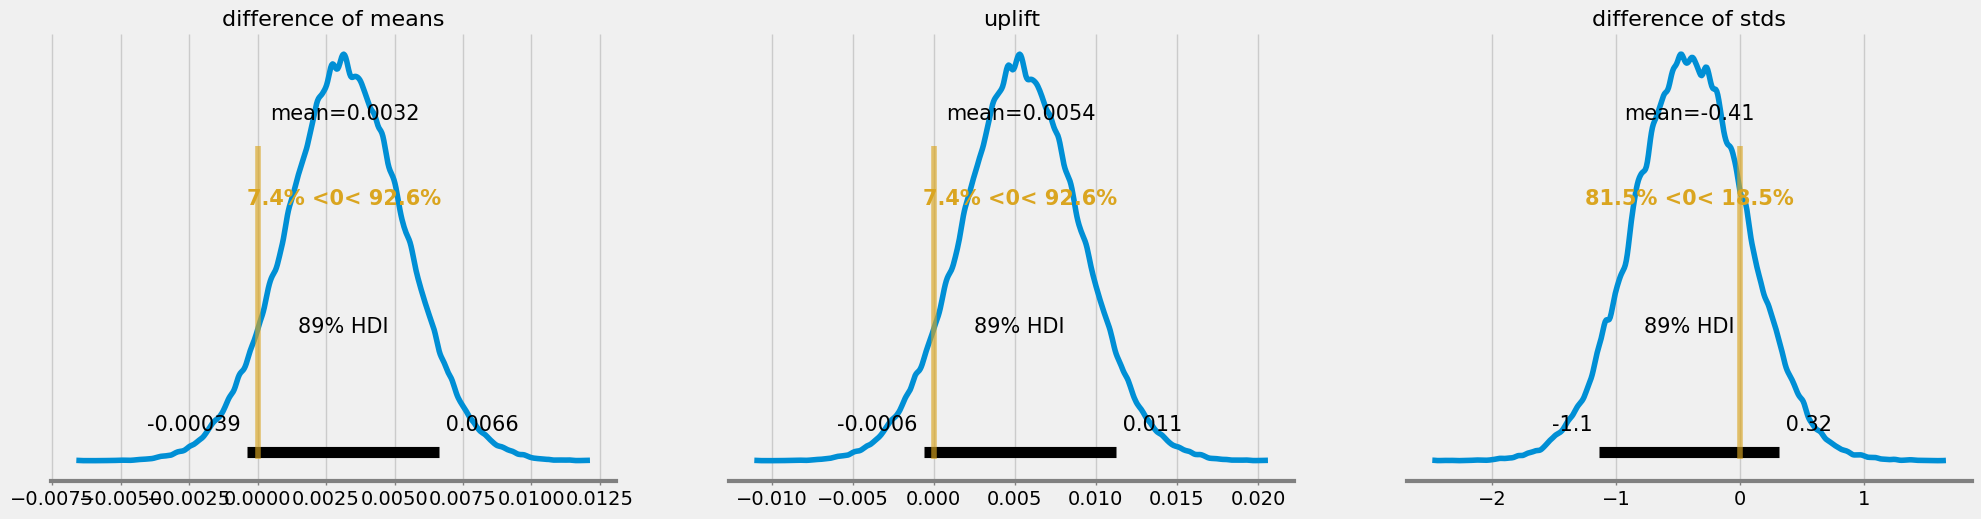

In [185]:
pm.plot_posterior(
    data=trace_cr_best,
    var_names=['difference of means', 'uplift', 'difference of stds'],
    ref_val_color='goldenrod',
    ref_val=0,
    hdi_prob=.89
);

In [171]:
print(f'Probability of Test Mean is higher than Control:\
 {round(prob_compare_posterior_diff_to_threshold(trace_cr_best, "difference of means", 0), 5)}')

Probability of Test Mean is higher than Control: 0.92633


# Test #2

## Generate some Data

##### Generate a row of descrete random events and add a number of outliers

In [92]:
# Generate a row of descrete random events
control = stats.poisson.rvs(mu=0.9, loc=0, size=100000, random_state=12)
test_2 = stats.poisson.rvs(mu=.9185, loc=0, size=100000, random_state=12)
# Add a number of outliers
n_outliers = 5
control = np.append(control, np.random.default_rng(12).integers(0, 5, n_outliers))
test_2 = np.append(test_2, np.random.default_rng(12).integers(0, 5, n_outliers))

##### Assign hashes

In [93]:
control_id = np.array([int(hashlib.md5(f'hash{str(i)}'.encode('utf_8')).hexdigest(), 16) for i in range(len(control))])
test_2_id = np.array([int(hashlib.md5(f'hash{str(i)}'.encode('utf_8')).hexdigest(), 16) for i in range(len(test_2))])

if len(set(test_2_id)) == len(test_2) and len(set(control_id)) == len(control):
    print('Hashes assigned')
else:
    print('Error')

Hashes assigned


##### Create DataFrame with prepared data

In [94]:
# Add division by Control and Test groups
data_2 = pd.DataFrame(
    data={
        'id': np.r_[control_id, test_2_id],
        'group_name': np.r_[np.repeat('Control', len(control)), np.repeat('Test', len(test_2))],
        'ride_request_clicks': np.r_[control, test_2]
    }
)
# Create CR metric
data_2['ride_request_is_click'] = data_2['ride_request_clicks'] > 0
data_2.head(4)

,id,group_name,ride_request_clicks,ride_request_is_click
0,294656076722992131643929581989213614422,Control,0,False
1,1032905646386335856508929738930080603,Control,1,True
2,117653356252977005139235343122285202191,Control,1,True
3,34968446932843456519540442248542660464,Control,2,True


## Observe the Data

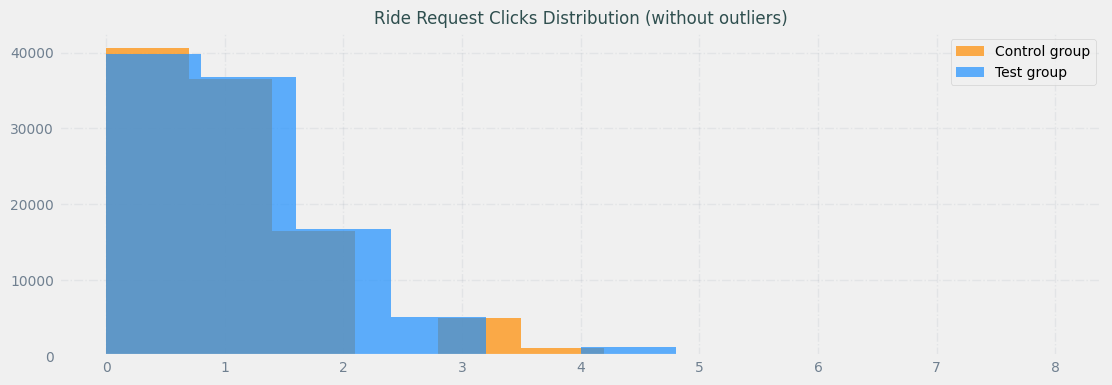

In [95]:
plt.figure(figsize=(12, 4))

plt.title('Ride Request Clicks Distribution (without outliers)', color='darkslategrey', fontsize=12)
plt.hist(control[:-n_outliers],  alpha=.7, color='darkorange', label='Control group')
plt.hist(test_2[:-n_outliers], alpha=.7, color='dodgerblue', label='Test group')

plt.xticks(color='slategrey', size=10)
plt.yticks(color='slategrey', size=10)
plt.grid(visible='both', which='major', linestyle='-.', color='slategrey', alpha=.1)

plt.legend(fontsize=10)
plt.show()

In [96]:
data_decriber_2 = pd.DataFrame(data={'Control': control, 'Test': test_2})
data_decriber_2.describe()

,Control,Test
count,100005.000000,100005.000000
mean,0.900385,0.919054
std,0.948873,0.958687
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,1.000000
75%,1.000000,1.000000
max,7.000000,8.000000


In [97]:
print(f'Zero requests share in Control group: {round(sum(control==0) / len(control) * 100, 2)}%')
print(f'Zero requests share in Test #1 group: {round(sum(test==0) / len(test) * 100, 2)}%')
print(f'Zero requests share in Test #2 group: {round(sum(test_2==0) / len(test_2) * 100, 2)}%')

Zero requests share in Control group: 40.66%
Zero requests share in Test #1 group: 40.33%
Zero requests share in Test #2 group: 39.87%


## Bucketization

- Group the users by 100 buckets
- Group data by group name and bucket id calculating mean metrics

In [98]:
data_2['bucket_id'] = data_2.apply(lambda x: x['id'] % 100, axis=1)
data_2_aggr = data_2.groupby(['group_name', 'bucket_id'])[['ride_request_clicks', 'ride_request_is_click']].mean()

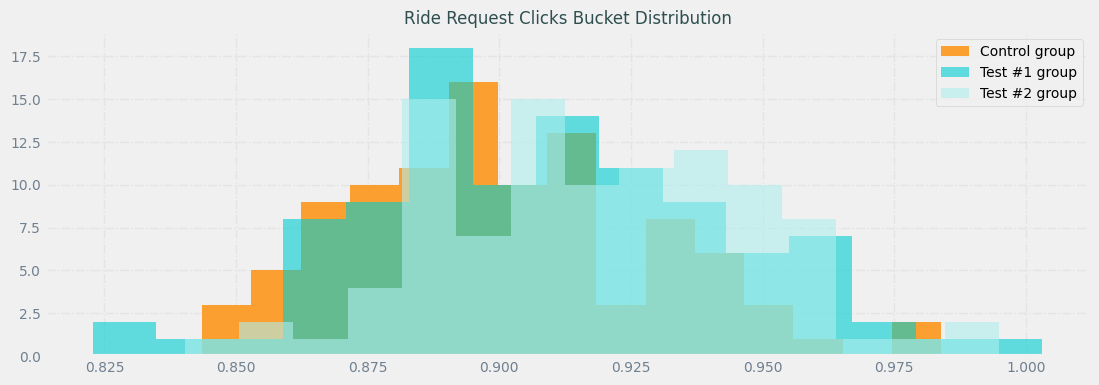

In [99]:
plt.figure(figsize=(12, 4))

plt.title('Ride Request Clicks Bucket Distribution', color='darkslategrey', fontsize=12)
plt.hist(
    data_2_aggr[data_2_aggr.index.get_level_values(0) == 'Control'].ride_request_clicks.values,
    bins=15,
    alpha=.8, 
    color='darkorange',
    label='Control group'
)
plt.hist(
    data_aggr[data_2_aggr.index.get_level_values(0) == 'Test'].ride_request_clicks.values,
    bins=15,
    alpha=.6,
    color='darkturquoise',
    label='Test #1 group'
)
plt.hist(
    data_2_aggr[data_2_aggr.index.get_level_values(0) == 'Test'].ride_request_clicks.values,
    bins=15,
    alpha=.6,
    color='paleturquoise',
    label='Test #2 group'
)

plt.xticks(color='slategrey', size=10)
plt.yticks(color='slategrey', size=10)
plt.grid(visible='both', which='major', linestyle='-.', color='slategrey', alpha=.1)

plt.legend(fontsize=10)
plt.show()

## Perform AB Frequentist Approach with T-test

### Mean metric

##### Bucket data with outliers

In [100]:
t_stat, p_value = t_test(
    data_2_aggr[data_2_aggr.index.get_level_values(0) == 'Test'].ride_request_clicks.values,
    data_2_aggr[data_2_aggr.index.get_level_values(0) == 'Control'].ride_request_clicks.values,
)
print('t-statistics:', round(t_stat, 3), 'p-value:', round(p_value, 5),
     'Significant' if p_value < .05 else 'Non Significant'
)

t-statistics: 4.508 p-value: 1e-05 Significant


### CR metric

##### CR metric estimated via Z-Test

In [101]:
z_score, p_value = z_test(
    data_2[data_2.group_name == 'Test'].ride_request_is_click.values,
    data_2[data_2.group_name == 'Control'].ride_request_is_click.values
)
print('z_score:', round(z_score, 3), 'p-value:', round(p_value, 5),
     'Significant' if p_value < .05 else 'Non Significant'
)

z_score: 3.57 p-value: 0.00036 Significant


##### CR metric estimated via T-Test

In [102]:
t_stat, p_value = t_test(
    data_2[data_2.group_name == 'Test'].ride_request_is_click.values,
    data_2[data_2.group_name == 'Control'].ride_request_is_click.values
)
print('t-statistics:', round(t_stat, 3), 'p-value:', round(p_value, 5),
     'Significant' if p_value < .05 else 'Non Significant'
)

t-statistics: 3.57 p-value: 0.00036 Significant


## Perform Bayesian Model

### Mean metric

In [112]:
test_2_values = data_2_aggr[data_2_aggr.index.get_level_values(0) == 'Test'].ride_request_clicks.values
control_2_values = data_2_aggr[data_2_aggr.index.get_level_values(0) == 'Control'].ride_request_clicks.values

In [113]:
pooled_mean = np.r_[test_2_values, control_values].mean()
pooled_std = np.r_[test_2_values, control_values].std()

tau = 1. / np.sqrt(1000. * pooled_std)

In [116]:
with pm.Model() as model:
    # Set the prior means
    mu_Test = pm.Normal('mu_Test', mu=pooled_mean, tau=tau)
    mu_Control = pm.Normal('mu_Control', mu=pooled_mean, tau=tau)
    
    # Set the prior standard deviations
    std_Test = pm.Uniform('std_Test', pooled_std / 1000., pooled_std * 1000.)
    std_Control = pm.Uniform('std_Control', pooled_std / 1000., pooled_std * 1000.)

    # Set the prior for degrees of freedom
    nu_minus_1 = pm.Exponential('nu-1', 1./29)
    
    obs_Test = pm.StudentT('obs_Test',
                       nu=nu_minus_1+1,
                       mu=mu_Test,
                       sigma=1.0/std_Test**2,
                       observed=test_2_values)
    
    obs_Control = pm.StudentT('obs_Control',
                       nu=nu_minus_1+1,
                       mu=mu_Control,
                       sigma=1.0/std_Control**2,
                       observed=control_values)
    
    diff_of_means = pm.Deterministic('difference of means',  mu_Test-mu_Control)
    uplift = pm.Deterministic('uplift', diff_of_means / mu_Control)
    diff_of_stds = pm.Deterministic('difference of stds',  std_Test-std_Control)
    effect_size = pm.Deterministic('effect size',
                                   diff_of_means / np.sqrt((std_Test**2 + std_Control**2) / 2))

    start = pm.find_MAP()
    step = pm.Metropolis(vars=[mu_Test, mu_Control, std_Test, std_Control, nu_minus_1])
    trace_2 = pm.sample(draws=25000, tune=5000, cores=6, step=step, initvals=start)

Multiprocess sampling (6 chains in 6 jobs)
CompoundStep
>Metropolis: [mu_Test]
>Metropolis: [mu_Control]
>Metropolis: [std_Test]
>Metropolis: [std_Control]
>Metropolis: [nu-1]


Sampling 6 chains for 5_000 tune and 25_000 draw iterations (30_000 + 150_000 draws total) took 16 seconds.


#### Visualization

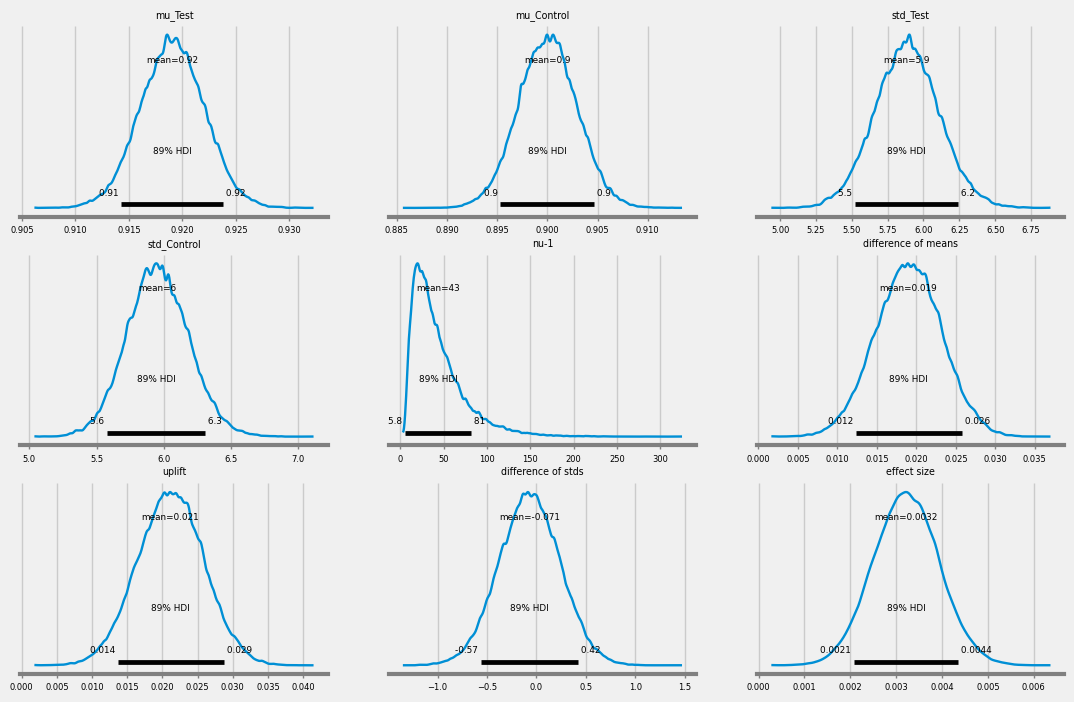

In [184]:
pm.plot_posterior(
    data=trace_2,
    figsize=(12,8),
    textsize=6,
    hdi_prob=.89
);

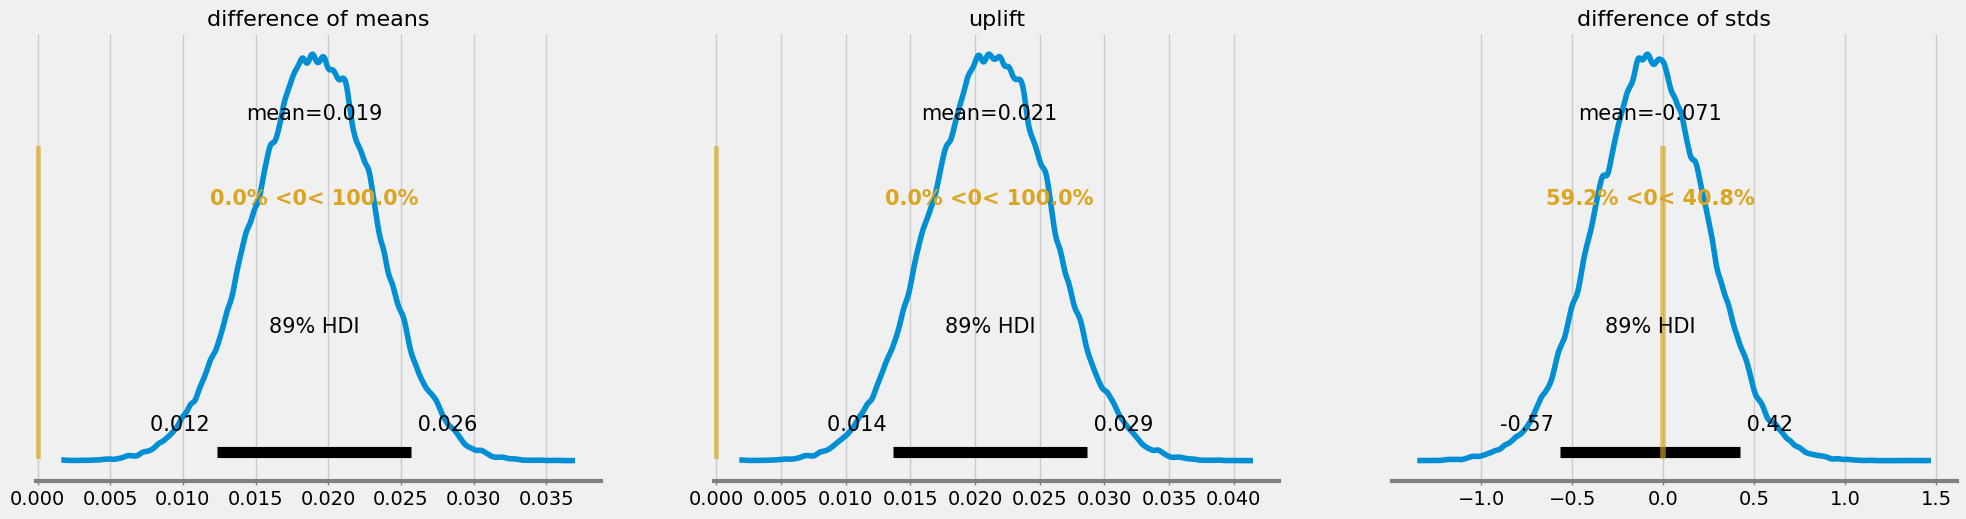

In [183]:
pm.plot_posterior(
    data=trace_2,
    var_names=['difference of means', 'uplift', 'difference of stds'],
    ref_val=0,
    ref_val_color='goldenrod',
    hdi_prob=.89
);

In [172]:
print(f'Probability of Test Mean is higher than Control:\
 {round(prob_compare_posterior_diff_to_threshold(trace_2, "difference of means", 0), 5)}')

Probability of Test Mean is higher than Control: 1.0


#### Equivalence Test
[Region of Practical Equivalence (ROPE)](https://easystats.github.io/bayestestR/articles/region_of_practical_equivalence.html)

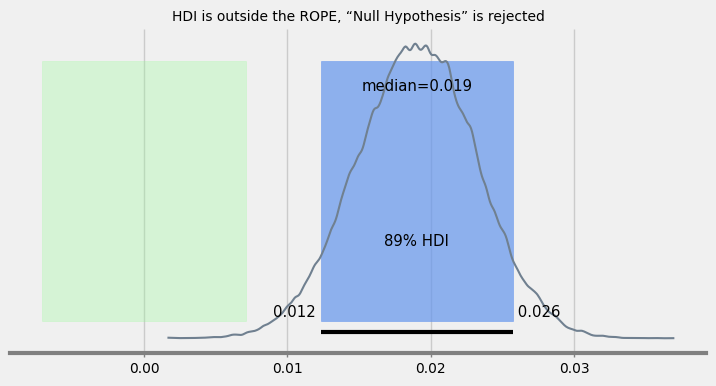

In [182]:
equivalence_test(trace_2, 'difference of means', .89, 'difference of stds')

#### Calculate Point Estimates

In [122]:
uplift = np.concatenate(trace_2.posterior['uplift'])

perc_30 = np.percentile(uplift, 30)
perc_50 = np.percentile(uplift, 50)
perc_70 = np.percentile(uplift, 70)

def get_prob_from_point(arr, point):
    return np.sum(arr >= point) / len(arr)

print(f'{round(get_prob_from_point(uplift, perc_30)*100)}% probability to obtain uplift more than {round(perc_30*100,2)}%')
print(f'{round(get_prob_from_point(uplift, perc_50)*100)}% probability to obtain uplift more than {round(perc_50*100,2)}%')
print(f'{round(get_prob_from_point(uplift, perc_70)*100)}% probability to obtain uplift more than {round(perc_70*100,2)}%')


70% probability to obtain uplift more than 1.87%
50% probability to obtain uplift more than 2.12%
30% probability to obtain uplift more than 2.36%


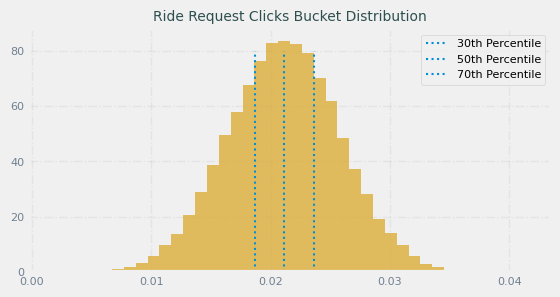

In [123]:
plt.figure(figsize=(6, 3))

plt.title('Ride Request Clicks Bucket Distribution', color='darkslategrey', fontsize=10)
plt.hist(
    uplift,
    color='goldenrod',
    alpha=.7,
    bins=40,
    density=True
)
plt.vlines(perc_30, 0, 80, linestyles='dotted', linewidth=1.5, label='30th Percentile')
plt.vlines(perc_50, 0, 80, linestyles='dotted', linewidth=1.5, label='50th Percentile')
plt.vlines(perc_70, 0, 80, linestyles='dotted', linewidth=1.5, label='70th Percentile')

plt.xticks(color='slategrey', size=8)
plt.yticks(color='slategrey', size=8)
plt.grid(visible='both', which='major', linestyle='-.', color='slategrey', alpha=.1)

plt.legend(fontsize=8)
plt.show();

### CR metric

In [145]:
control_values_raw = data_2[data_2.group_name == 'Control'].ride_request_is_click.values * 1
control_values_bucket = data_2_aggr[data_2_aggr.index.get_level_values(0) == 'Control'].ride_request_is_click.values

print('Raw data mean:', round(control_values_raw.mean(), 5))
print('Bucket data mean:', round(control_values_bucket.mean(), 5))

Raw data mean: 0.59343
Bucket data mean: 0.59342


#### Model for Raw Data

In [146]:
test_2_values = data_2[data_2.group_name == 'Test'].ride_request_is_click.values * 1
control_2_values = data_2[data_2.group_name == 'Control'].ride_request_is_click.values * 1

In [147]:
with pm.Model() as model_cr:
    # Set the prior means
    p_Test = pm.Uniform('p_Test', 0, 1)
    p_Control = pm.Uniform('p_Control', 0, 1)
    
    # Define the deterministic delta and uplift functions
    delta = pm.Deterministic('delta', p_Test - p_Control)
    uplift = pm.Deterministic('uplift', delta / p_Control)
    
    # Set of observations
    obs_Test = pm.Bernoulli('obs_Test', p_Test, observed=test_2_values)
    obs_Control = pm.Bernoulli('obs_Control', p_Control, observed=control_2_values)

    start = pm.find_MAP()
    step = pm.Metropolis(vars=[p_Test, p_Control])
    trace_2_cr = pm.sample(draws=25000, tune=5000, cores=6, step=step, initvals=start)

Multiprocess sampling (6 chains in 6 jobs)
CompoundStep
>Metropolis: [p_Test]
>Metropolis: [p_Control]


Sampling 6 chains for 5_000 tune and 25_000 draw iterations (30_000 + 150_000 draws total) took 28 seconds.


##### Visualization

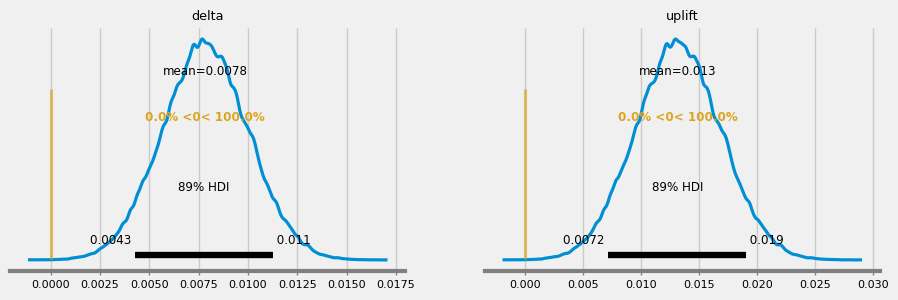

In [181]:
pm.plot_posterior(
    data=trace_2_cr,
    figsize=(10,3),
    textsize=8,
    var_names=['delta', 'uplift'],
    ref_val_color='goldenrod',
    ref_val=0,
    hdi_prob=.89
);

In [173]:
print(f'Probability of Test CR is higher than Control:\
 {round(prob_compare_posterior_diff_to_threshold(trace_2_cr, "delta", 0), 5)}')

Probability of Test CR is higher than Control: 0.99989


#### BEST Model for Bucket Data

In [149]:
test_2_values = data_2_aggr[data_2_aggr.index.get_level_values(0) == 'Test'].ride_request_is_click.values
control_2_values = data_2_aggr[data_2_aggr.index.get_level_values(0) == 'Control'].ride_request_is_click.values

In [150]:
pooled_mean = np.r_[test_2_values, control_2_values].mean()
pooled_std = np.r_[test_2_values, control_2_values].std() 

tau = 1. / np.sqrt(1000. * pooled_std)

In [151]:
with pm.Model() as model_cr_best:
    # Set the prior means
    mu_Test = pm.Normal('mu_Test', mu=pooled_mean, tau=tau)
    mu_Control = pm.Normal('mu_Control', mu=pooled_mean, tau=tau)
    
    # Set the prior standard deviations
    std_Test = pm.Uniform('std_Test', pooled_std / 1000., pooled_std * 1000.)
    std_Control = pm.Uniform('std_Control', pooled_std / 1000., pooled_std * 1000.)

    # Set the prior for degrees of freedom
    nu_minus_1 = pm.Exponential('nu-1', 1./29)
    
    obs_Test = pm.StudentT('obs_Test',
                       nu=nu_minus_1+1,
                       mu=mu_Test,
                       sigma=1.0/std_Test**2,
                       observed=test_2_values)
    
    obs_Control = pm.StudentT('obs_Control',
                       nu=nu_minus_1+1,
                       mu=mu_Control,
                       sigma=1.0/std_Control**2,
                       observed=control_2_values)
    
    diff_of_means = pm.Deterministic('difference of means',  mu_Test-mu_Control)
    diff_of_stds = pm.Deterministic('difference of stds',  (std_Test-std_Control)/2)
    uplift = pm.Deterministic('uplift', diff_of_means / mu_Control)
    effect_size = pm.Deterministic('effect size',
                                   diff_of_means / np.sqrt((std_Test**2 + std_Control**2) / 2))

    start = pm.find_MAP()
    step = pm.Metropolis(vars=[mu_Test, mu_Control, std_Test, std_Control, nu_minus_1])
    trace_2_cr_best = pm.sample(draws=25000, tune=5000, cores=6, initvals=start, step=step)

Multiprocess sampling (6 chains in 6 jobs)
CompoundStep
>Metropolis: [mu_Test]
>Metropolis: [mu_Control]
>Metropolis: [std_Test]
>Metropolis: [std_Control]
>Metropolis: [nu-1]


Sampling 6 chains for 5_000 tune and 25_000 draw iterations (30_000 + 150_000 draws total) took 16 seconds.


##### Visualization

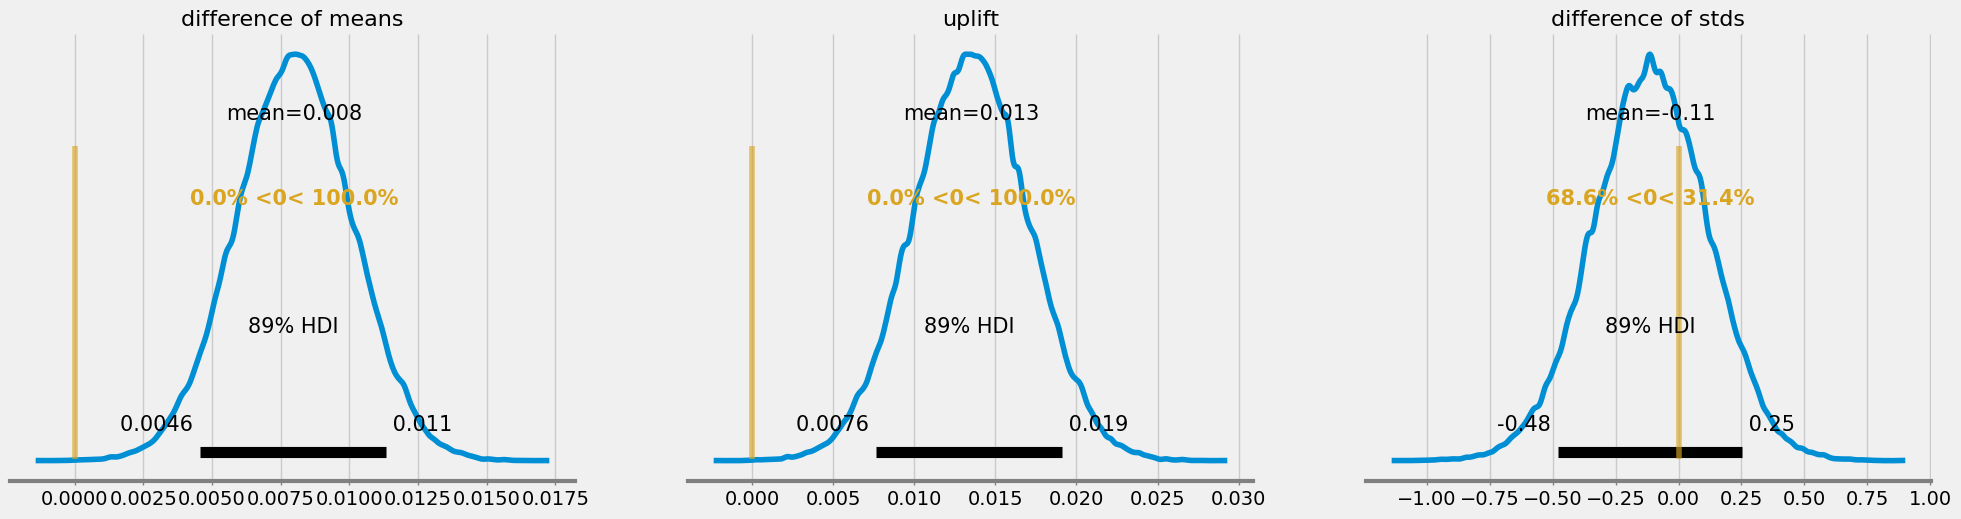

In [180]:
pm.plot_posterior(
    data=trace_2_cr_best,
    var_names=['difference of means', 'uplift', 'difference of stds'],
    ref_val_color='goldenrod',
    ref_val=0,
    hdi_prob=.89
);

In [167]:
print(f'Probability of Test CR is higher than Control:\
 {round(prob_compare_posterior_diff_to_threshold(trace_2_cr, "delta", 0), 5)}')
print(f'Probability of Test Mean is higher than Control:\
 {round(prob_compare_posterior_diff_to_threshold(trace_2_cr_best, "difference of means", 0), 5)}')

Probability of Test CR is higher than Control: 0.99989
Probability of Test Mean is higher than Control: 0.99993


#### Equivalence Test
[Region of Practical Equivalence (ROPE)](https://easystats.github.io/bayestestR/articles/region_of_practical_equivalence.html)

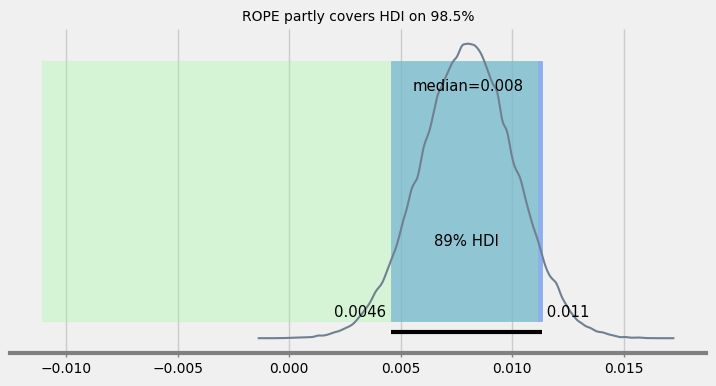

In [179]:
equivalence_test(trace_2_cr_best, 'difference of means', .89, 'difference of stds')